In [67]:
# !pip uninstall opencv-python 
# !pip install xlwt

# !pip install opencv-python
# !pip install pytesseract
# !conda install pandas
# !pip install easyocr
# !pip install pytesseract


In [68]:
from commonfunctions import *
import pytesseract
import utlis
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
try:
    from PIL import Image
except ImportError:
    import Image
%matplotlib inline
%load_ext autoreload
%autoreload 2

pytesseract.pytesseract.tesseract_cmd = r"C:\Users\ahmed\AppData\Local\Programs\Tesseract-OCR\tesseract.exe"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
# Functions [show, scann]

def _imshow(img):
    cv2.imshow('image', img)
    plt.show()
    # specify a wait key from keyboard
    k = cv2.waitKey(0) & 0xFF

    if k == 27: #esc in keyboard
        cv2.destroyAllWindows() #close the window   

    elif k == ord('s'): #if order is s save the image
        cv2.imwrite('Test.png', img) #write image in your pc     
        cv2.destroyAllWindows() # close the window 

def _scannar(img):
    heightImg = img.shape[1]
    widthImg  = img.shape[0]
    imgBlank = np.zeros((heightImg,widthImg, 3), np.uint8) # CREATE A BLANK IMAGE FOR TESTING DEBUGING IF REQUIRED
    # imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) # CONVERT IMAGE TO GRAY SCALE
    imgBlur = cv2.GaussianBlur(img, (3, 3), 1) # ADD GAUSSIAN BLUR
    imgBlur = img

    imgsobel = sobel(imgBlur)
    imgThreshold = cv2.Canny(imgBlur,100,150) # APPLY CANNY BLUR
    kernel = np.ones((3, 3))
    imgDial = cv2.dilate(imgThreshold, kernel, iterations=2) # APPLY DILATION
    imgThreshold = cv2.erode(imgDial, kernel, iterations=1)  # APPLY EROSION



    ## FIND ALL COUNTOURS
    imgContours = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    imgBigContour = img.copy() # COPY IMAGE FOR DISPLAY PURPOSES
    contours, hierarchy = cv2.findContours(imgThreshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # FIND ALL CONTOURS
    cv2.drawContours(imgContours, contours, -1, (0, 255, 0), 10) # DRAW ALL DETECTED CONTOURS
    imgThreshold = cv2.cvtColor(imgThreshold,cv2.COLOR_BAYER_BG2BGR)


    # FIND THE BIGGEST COUNTOUR
    biggest, maxArea = utlis.biggestContour(contours) # FIND THE BIGGEST CONTOUR

    if biggest.size != 0:
        biggest=utlis.reorder(biggest)
        cv2.drawContours(imgBigContour, biggest, -1, (0, 255, 0), 20) # DRAW THE BIGGEST CONTOUR
        imgBigContour = utlis.drawRectangle(imgBigContour,biggest,2)
        pts1 = np.float32(biggest) # PREPARE POINTS FOR WARP
        pts2 = np.float32([[0, 0],[widthImg, 0], [0, heightImg],[widthImg, heightImg]]) # PREPARE POINTS FOR WARP
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        imgWarpColored = cv2.warpPerspective(img, matrix, (widthImg, heightImg))

        #REMOVE 20 PIXELS FORM EACH SIDE
        imgWarpColored=imgWarpColored[20:imgWarpColored.shape[0] - 20, 20:imgWarpColored.shape[1] - 20]

        # APPLY ADAPTIVE THRESHOLD
        # imgAdaptiveThre= cv2.adaptiveThreshold(imgWarpColored, 255, 1, 1, 7, 2)
        # imgAdaptiveThre = cv2.bitwise_not(imgAdaptiveThre)
        imgAdaptiveThre=cv2.medianBlur(imgWarpColored,3)

    thres = 160
    img_bin = np.copy(imgAdaptiveThre)
    img_bin[imgAdaptiveThre < thres] = 0
    img_bin[imgAdaptiveThre >= thres] = 255
    img = img_bin
    # _imshow(img)
    show_images([img_bin])
    return img

In [70]:
# Read img wit GRAY scale 
file = r"dataSet\1.jpg"
img = cv2.imread(file) # 0 for gray scale , 1 for color , -1 for alpha channel
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_imshow(img_gray)
# cv2.imshow('image', img)
# plt.show()
# # specify a wait key from keyboard
# k = cv2.waitKey(0) & 0xFF

# if k == 27: #esc in keyboard
#     cv2.destroyAllWindows() #close the window   

# elif k == ord('s'): #if order is s save the image
#     cv2.imwrite('Test.png', img) #write image in your pc     
#     cv2.destroyAllWindows() # close the window 

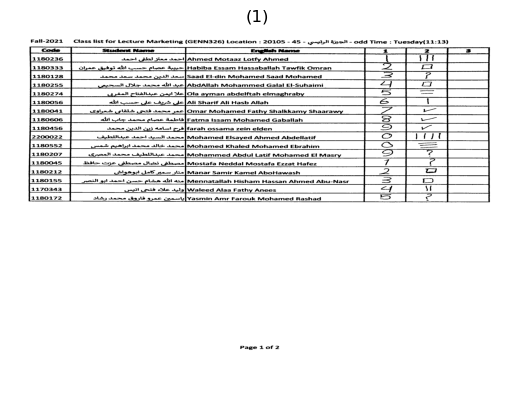

In [71]:

# scan the image
# scan = input("Do you want to scan the image?")
if True:
    img_sc = _scannar(img_gray)
    _imshow(img_sc)

In [72]:
# Binary img & negative transform
thresh,img_bin = cv2.threshold(img_sc,50,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

## method 2
# img_bin = np.copy(img)
# thres = 200
# img_bin[img < thres] = 1
# img_bin[img >= thres] = 0
# plotting = plt.imshow(img_bin,cmap='gray')
# plt.show()

## Negative transform
img_bin = 255 - img_bin
# _imshow(img_bin)



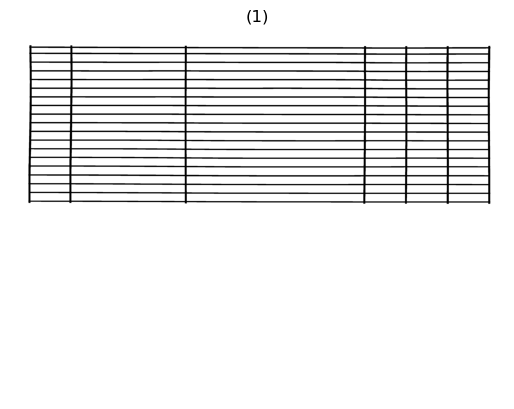

In [73]:

# Get table stracture

# Length(width) of kernel as 100th of total width
kernel_len = np.array(img_bin).shape[1]//200
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT  , (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT  , (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT  , (4, 4))

# Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=4)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=5)


# Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=15)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=15)


# Combine horizontal and vertical lines in a new third image, with both having same weight.
table_img = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0)

#Eroding and thesholding the image
table_img = cv2.erode(~table_img, kernel, iterations=2)
thresh, table_img = cv2.threshold(table_img,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# ?????????????? why what's the use of it ??????????????
# bitxor = cv2.bitwise_xor(img_gray,table_img)
# bitnot = cv2.bitwise_not(bitxor)


#Plotting the generated image
show_images([table_img])
# _imshow(table_img)
# show_images([])
img_vh = table_img


In [74]:

# Detect contours for following box detection


contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes), key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)


# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")
cont_img = np.copy(img_vh)
cv2.drawContours(cont_img, contours,4, (0, 255, 0), 0)
# show_images([cont_img])
cont_img = img_vh

# Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

# Get mean of heights
mean = np.mean(heights)

# Create list box to store all boxes in
box = []

# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w < 10000 and w > 200  and  h < 500):
        # image = cv2.rectangle(img_sc, (x, y), (x+w, y+h), (0, 255, 0),0)
        box.append([x, y, w, h])

number of contours: 110
Number of contours = 110


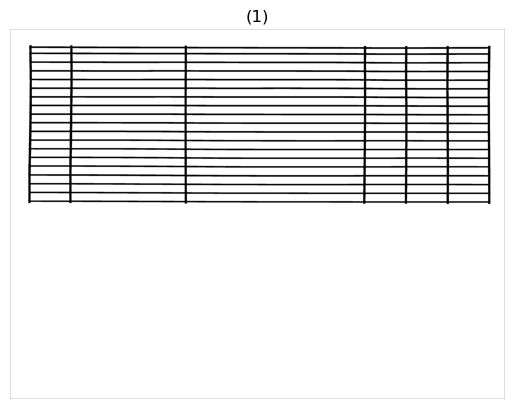

In [75]:

print(f"number of contours: {len(contours)}")
# print(contours[0])
img_vhcopy = np.copy(table_img)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

# Draw contours



print("Number of contours = " + str(len(contours)))

# print(contours[0])
cont_img = np.copy(table_img)
cv2.drawContours(cont_img, contours,-1, (0, 255, 0), 0)
show_images([cont_img])
cont_img = table_img



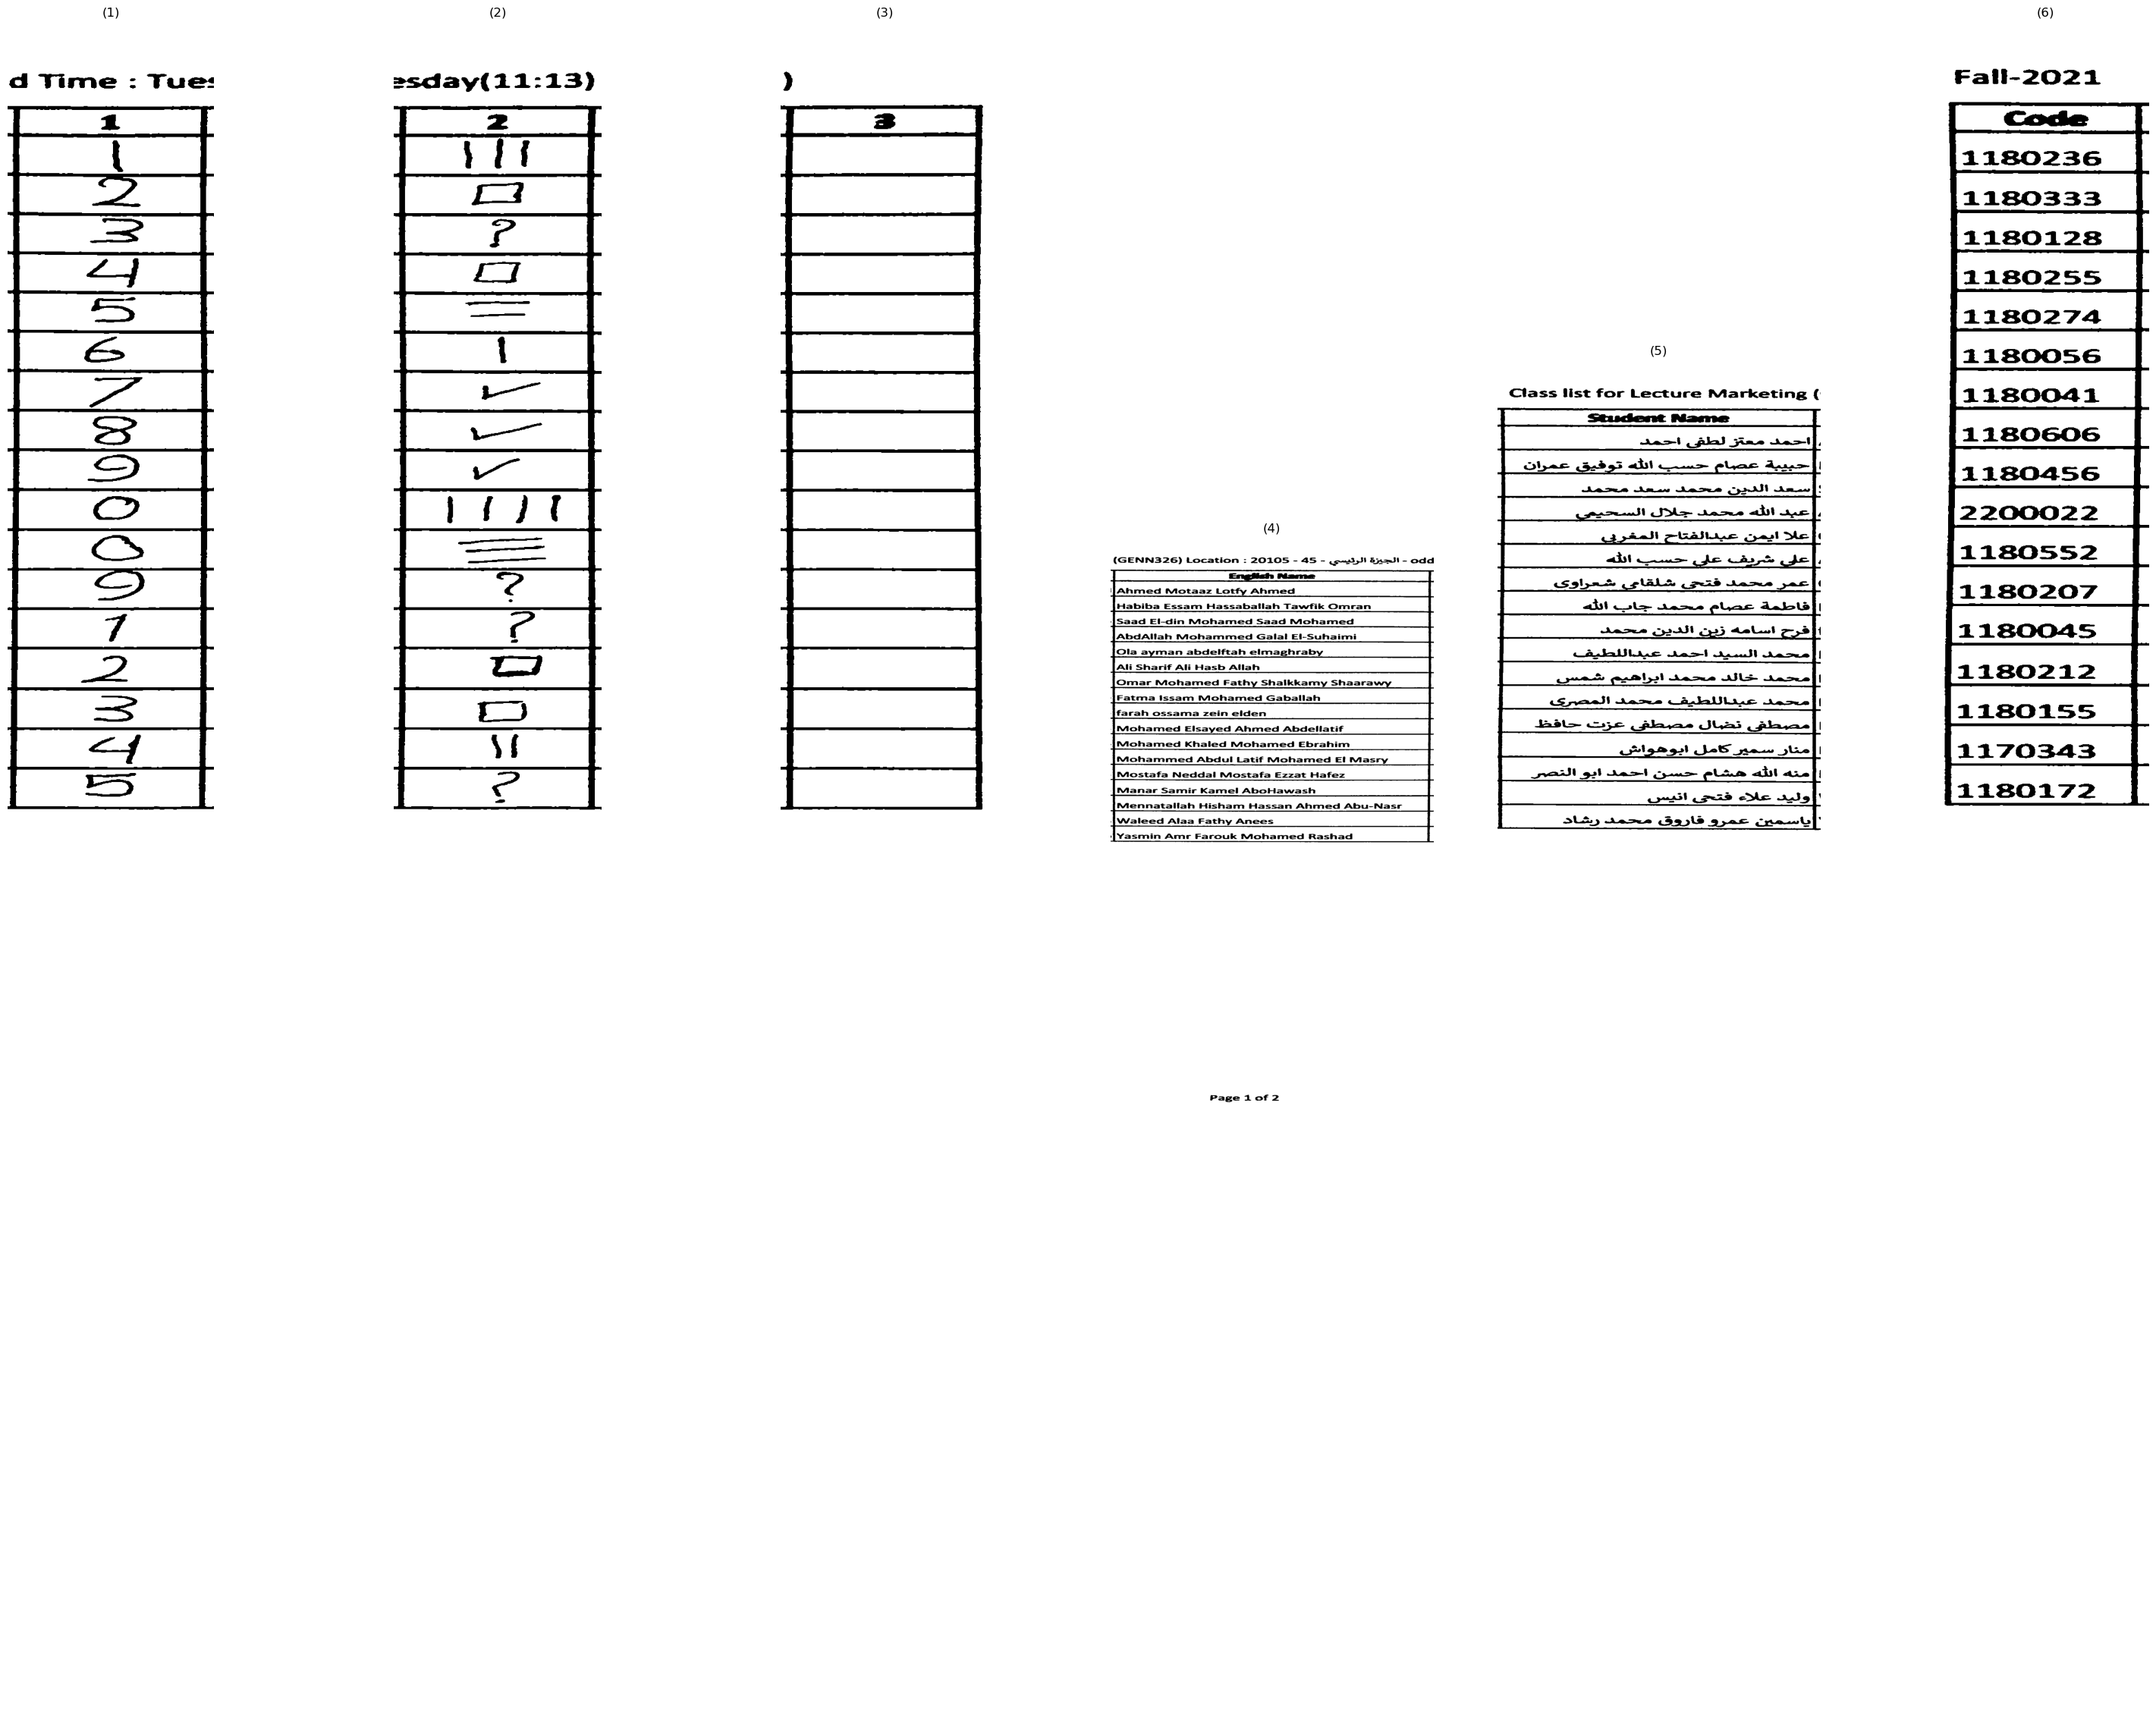

[503, 153, 906, 40]


In [77]:

######################################
# Convert image into colunms 
######################################
margin = 25
cols = []
for i in range(5,-1,-1):
    col = img_sc[:,box[i][0]-margin:box[i][0]+box[i][2]+margin]
    cols.append(col)
    
show_images([cols[0],cols[1],cols[2],cols[3],cols[4],cols[5]])
cells_img = []
print(box[1])
for i in range(len(box)):
    img3 = img[box[i][1]:box[i][1]+box[i][3],box[i][0]:box[i][0]+box[i][2]]
    cells_img.append(img3)




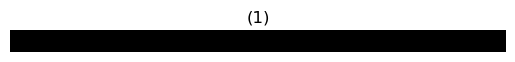

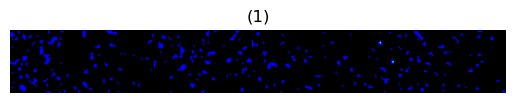

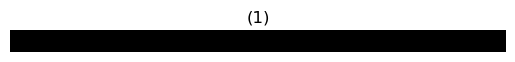

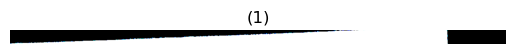

TypeError: Unsupported image object

In [79]:

config = '8'    
cell_list = []
i = 1
img5 = cells_img[i]
_, img5 = cv2.threshold(img5,70,255,cv2.THRESH_BINARY)
show_images([img5])
pytesseract.image_to_string(img5)

_, cells_img[0] = cv2.threshold(cells_img[0],70,255,cv2.THRESH_BINARY)
celltext = pytesseract.image_to_string(cells_img[0],config=config,lang="eng")
cell_list.append(celltext)
show_images([cells_img[0]])
print(celltext)

for i in range(1,len(cells_img)):
    _, cells_img[i] = cv2.threshold(cells_img[i],90,255,cv2.THRESH_BINARY)
    celltext = pytesseract.image_to_string(cells_img[i],config=config,lang="eng")
    cell_list.append(celltext)
    show_images([cells_img[i]])
    print(celltext)

print(cell_list[1])


In [ ]:

################Excel###################

arr = np.array(cell_list)
dataframe = pd.DataFrame(arr)
print(dataframe)
data = dataframe.style.set_properties(align="left")
# Converting it in a excel-file
data.to_excel("E:\CUFE\Fall22\IP\Project-2022\GradesAutoFiller-main\GradesAutoFiller-main\Module1\output.xlsx",index=None,header="code")
